### 1. Imports

In [9]:
# Standard Library
import os
from pathlib import Path
import time
from copy import deepcopy
from itertools import product

# Scientific Computing and Image Processing
import numpy as np
import cv2
from scipy.ndimage import label, zoom, binary_dilation
from scipy.optimize import minimize
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Image Analysis
from skimage import measure
from skimage.measure import marching_cubes

# Machine Learning
from sklearn.neighbors import NearestNeighbors


part_colors = {
    "full_building":    [(253, 248, 96)],
    "chhatris":         [(1, 220, 5)],
    "plinth":           [(63, 138, 173)],
    "dome":             [(190, 0, 255)],
    "front_minarets":   [(0, 0, 255)],
    "back_minarets":    [(5, 223, 223)],
    "small_minarets":   [(255, 180, 80)],
    "main_door":        [(180, 140, 255)],
    "windows":          [(255, 120, 230)],
    "background":       [(216, 224, 251)]
}

part_colors_np = {k: np.array(v) for k,v in part_colors.items()}




### 2. Functions

In [12]:
# === LOADING & PREPROCESSING ===

def resize_image(img, scale=2):
    h, w = img.shape[:2]
    return cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_NEAREST)
    
def load_voxel_grid(npz_path):
    data = np.load(npz_path)
    voxel_grid = data["voxel_grid"]
    voxel_grid = np.flip(voxel_grid, axis=1)  # Flip Y for consistency
    return voxel_grid
   
def resize_voxel_grid(voxel_grid, scale=2):
    if voxel_grid.ndim == 4:
        zoom_factors = (1/scale, 1/scale, 1/scale, 1)
    else:
        zoom_factors = (1/scale, 1/scale, 1/scale)

    return zoom(voxel_grid, zoom=zoom_factors, order=0)  # order=0 for nearest neighbor (preserve labels/colors)

def voxel_grid_to_points(grid, axis='z', colormap='viridis', stride=2):
    W, H, D= grid.shape[:3]
    is_color = grid.ndim == 4 and grid.shape[3] == 3
    mask = np.any(grid, axis=-1) if is_color else grid != 0
    mask_ds = mask[::stride, ::stride, ::stride]
    xs, ys, zs = np.where(mask_ds)
    pts = np.stack([xs, ys, zs], axis=1).astype(np.float32) * stride

    if is_color:
        colors = grid[::stride, ::stride, ::stride][xs, ys, zs]
    else:
        vals = {'x': xs, 'y': ys, 'z': zs}[axis] / {'x': W - 1, 'y': H - 1, 'z': D - 1}[axis]
        colors = (plt.get_cmap(colormap)(vals)[:, :3] * 255).astype(np.uint8)

    return pts, colors, (W, H, D)
    
def extract_top_k_components(voxel_grid, color, k=4):
    mask = np.all(voxel_grid == color, axis=-1)
    labeled, _ = label(mask, structure=np.ones((3, 3, 3)))
    heights = [(i, np.ptp(np.argwhere(labeled == i)[:, 1])) for i in range(1, labeled.max() + 1)]
    top_ids = [idx for idx, _ in sorted(heights, key=lambda x: -x[1])[:k]]
    top_mask = np.isin(labeled, top_ids)
    filtered = voxel_grid.copy()
    filtered[mask & (~top_mask)] = 0
    return filtered

def compute_scene_center(voxel_grid):
    z, y, x = np.where(np.any(voxel_grid != 0, axis=-1))
    pts = np.stack([x, y, z], axis=1).astype(np.float32)
    return pts.mean(axis=0)

# === VISUALIZATION ===
def plot_voxel(points, colors=None):
    if colors is None:
        color_input = 'blue'
    else:
        colors = np.asarray(colors)
        if colors.ndim == 2 and colors.shape[1] == 3 and colors.max() > 1:
            colors = colors / 255
        color_input = colors

    fig = go.Figure(go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers', marker=dict(size=2, color=color_input, opacity=1)
    ))
    fig.update_layout(scene=dict(aspectmode='data'), title='3D Visualization')
    fig.show()

# === GEOMETRY & PROJECTION ===
def look_at_rotation(eye, target, up=np.array([0, 1, 0], dtype=np.float32)):
    z = target - eye
    z /= np.linalg.norm(z)
    if np.allclose(np.abs(np.dot(z, up)), 1.0):
        up = np.array([0, 0, 1], dtype=np.float32)
    x = np.cross(up, z)
    x /= np.linalg.norm(x)
    y = np.cross(z, x)
    return np.stack([x, y, z], axis=0)

def get_voxel_points_by_parts(grid, part_colors, part_names):
    all_colors = []
    for name in part_names:
        all_colors.extend(part_colors.get(name, []))
    mask = np.zeros(grid.shape[:3], dtype=bool)
    for color in all_colors:
        mask |= np.all(grid == color, axis=-1)
    z, y, x = np.where(mask)
    pts = np.stack([x, y, z], axis=1).astype(np.float32)
    colors = grid[z, y, x]
    return pts, colors

def project_colored_voxels(pts3d, colors, cam_pos, target, f, cx, cy, H, W):
    R = look_at_rotation(cam_pos, target)
    pts_cam = (pts3d - cam_pos) @ R.T
    X, Y, Z = pts_cam.T
    Z = np.where(Z < 1e-8, 1e-8, Z)
    u = (X / Z) * f + cx
    v = -(Y / Z) * f + cy
    ui = np.round(u).astype(int)
    vi = np.round(v).astype(int)
    valid = (ui >= 0) & (ui < W) & (vi >= 0) & (vi < H)

    proj_img = np.zeros((H, W, 3), dtype=np.uint8)
    proj_img[vi[valid], ui[valid]] = colors[valid]
    return proj_img


# === EVALUATION ===
def compute_partwise_iou(proj_mask, gt_mask, part_colors):
    flat_proj = proj_mask.reshape(-1, 3)
    flat_gt = gt_mask.reshape(-1, 3)
    iou_per_part = {}
    total_ious = []

    for part, bgr_list in part_colors.items():
        proj_part = np.any([np.all(flat_proj == bgr, axis=1) for bgr in bgr_list], axis=0)
        gt_part = np.any([np.all(flat_gt == bgr, axis=1) for bgr in bgr_list], axis=0)
        inter = np.logical_and(proj_part, gt_part).sum()
        union = np.logical_or(proj_part, gt_part).sum()
        iou = inter / union if union > 0 else 0.0
        iou_per_part[part] = iou
        total_ious.append(iou)

    return iou_per_part, np.mean(total_ious)

def mask_parts_from_image(image, part_colors, selected_parts):
    mask = np.zeros_like(image)
    for part in selected_parts:
        for color in part_colors[part]:
            match = np.all(image == color, axis=-1)
            mask[match] = color
    return mask
# def mask_parts_from_image(image, part_colors, selected_parts):
#     mask = np.zeros_like(image)

#     for part in selected_parts:
#         color = np.array(part_colors[part])   # ONE RGB tuple

#         match = np.all(image == color, axis=-1)
#         mask[match] = color

#         print(f"Mask extraction: {part}, color {color}, matches = {np.sum(match)}")

#     return mask


def visualize_voxel_projection_iou(
    voxel_grid,
    part_colors,
    image,
    cam_params,
    mode='part_on_whole',  # 'part_on_whole', 'part_on_part', 'whole_on_whole', 'whole_on_whole_color'
    save=False,
    save_root='visualisation'
):
    def compute_mask(image, color):
        return np.all(image == color, axis=-1)

    def compute_iou(gt_mask, prj_mask):
        inter = np.logical_and(gt_mask, prj_mask).sum()
        union = np.logical_or(gt_mask, prj_mask).sum()
        return inter / union if union > 0 else 0.0

    def outline_projection(base, gt_mask, prj_mask):
        combined_mask = np.logical_and(gt_mask, prj_mask)
        outline = binary_dilation(combined_mask) & ~combined_mask
        base[outline] = [255, 255, 0]  # yellow outline
        return base

    if save:
        save_dir = os.path.join(save_root, mode)
        os.makedirs(save_dir, exist_ok=True)

    H, W = image.shape[:2]
    combined_mask_gt = np.zeros((H, W), dtype=bool)
    combined_mask_prj = np.zeros((H, W), dtype=bool)
    combined_proj = np.zeros_like(image, dtype=np.float32)
    BG_COLOR = np.array(part_colors["background"], dtype=np.uint8)


    for part, colors in part_colors.items():
        # Project voxel part
        pts, col = get_voxel_points_by_parts(voxel_grid, part_colors, [part])
        proj_img = project_colored_voxels(
            pts, col,
            cam_params['cam_pos'], cam_params['target'],
            cam_params['f'], cam_params['cx'], cam_params['cy'],
            H, W
        )
        # proj_img = np.flipud(proj_img)


        # Generate binary masks
        mask_gt = np.any([compute_mask(image, c) for c in colors], axis=0)
        mask_prj = np.any([compute_mask(proj_img, c) for c in colors], axis=0)

        combined_mask_gt |= mask_gt
        combined_mask_prj |= mask_prj
        combined_proj += proj_img.astype(np.float32)

        if mode in ['part_on_whole', 'part_on_part']:
            iou = compute_iou(mask_gt, mask_prj)

            if mode == 'part_on_whole':
                vis = (0.7 * proj_img + 0.3 * image).astype(np.uint8)

            elif mode == 'part_on_part':
                vis = np.zeros_like(image)
                vis[mask_gt] = image[mask_gt]
                vis[mask_prj] = proj_img[mask_prj]

                overlap = mask_gt & mask_prj
                blended_overlap = np.clip((0.7 * proj_f + 0.3 * image_front) * 1.5, 0, 255)

                blended_overlap = np.clip((0.7 * proj_img + 0.3 * image) * 1.5, 0, 255)
                vis[overlap] = blended_overlap[overlap].astype(np.uint8)

            vis = outline_projection(vis, mask_gt, mask_prj)

            plt.figure(figsize=(6, 6))
            plt.imshow(vis)
            plt.title(f"{part} | IoU: {iou:.3f}")
            plt.axis("off")

            if save:
                path = os.path.join(save_dir, f"{part}_overlay.png")
                plt.savefig(path)
                print(f"Saved {path}")
            plt.show()

  
    if mode == "whole_on_whole":
        combined_mask_gt = np.any(image != BG_COLOR, axis=-1)

        print("Visualizing combined binary projection vs. binary ground-truth...")
    
        overlap = combined_mask_gt & combined_mask_prj
        only_gt = combined_mask_gt & ~combined_mask_prj
        only_prj = combined_mask_prj & ~combined_mask_gt
    
        vis = np.zeros((H, W, 3), dtype=np.uint8)
        vis[only_gt]  = [0, 255, 0]     # GT only
        vis[only_prj] = [255, 0, 0]     # Projection only
        vis[overlap]  = [255, 255, 0]   # Overlap
    
        iou = compute_iou(combined_mask_gt, combined_mask_prj)
    
        plt.figure(figsize=(6, 6))
        plt.imshow(vis)
        plt.title(f"Combined Binary | IoU: {iou:.3f}")
        plt.axis("off")
    
        if save:
            path = os.path.join(save_dir, "combined_binary_overlay.png")
            plt.savefig(path)
            print(f"Saved {path}")
    
        plt.show()


    if mode == 'whole_on_whole_color':
        print("Visualizing full-color projection overlay...")

        proj_img = np.clip(combined_proj, 0, 255).astype(np.uint8)
        vis = (0.7 * proj_img + 0.3 * image).astype(np.uint8)

        plt.figure(figsize=(6, 6))
        plt.imshow(vis)
        plt.title("Combined Color Projection Overlay")
        plt.axis("off")

        if save:
            path = os.path.join(save_dir, f"combined_color_overlay.png")
            plt.savefig(path)
            print(f"Saved {path}")
        plt.show()

## Camera initialization

def auto_compute_initial_params_matching_bbox(voxel_grid, image, part_colors, parts_for_alignment, fov_deg=30):
    """
    Compute initial camera parameters so voxel projection roughly matches image mask bounding box.
    """
    H_img, W_img = image.shape[:2]
    voxel_pts, _ = get_voxel_points_by_parts(voxel_grid, part_colors, parts_for_alignment)
    seg_img = mask_parts_from_image(image, part_colors, parts_for_alignment)

    # Voxel 3D bounding box
    bbox_min = voxel_pts.min(axis=0)
    bbox_max = voxel_pts.max(axis=0)
    voxel_center = (bbox_min + bbox_max) / 2
    voxel_size = np.linalg.norm(bbox_max - bbox_min)

    # Image 2D mask bounding box
    mask = np.any(seg_img > 0, axis=-1)
    ys, xs = np.where(mask)
    img_bbox_min = np.array([xs.min(), ys.min()])
    img_bbox_max = np.array([xs.max(), ys.max()])
    img_bbox_center = (img_bbox_min + img_bbox_max) / 2
    img_bbox_width = np.linalg.norm(img_bbox_max - img_bbox_min)

    # Initial camera position (along +Z)
    # cam_pos = voxel_center + np.array([0, 0, voxel_size * 2.0])
    cam_pos = voxel_center + np.array([0, 0, -voxel_size * 2.0])

    target = voxel_center

    # Compute focal length from FOV and image height
    f = H_img / (2 * np.tan(np.deg2rad(fov_deg) / 2))

    # Estimate projected voxel width at that distance
    approx_voxel_proj_width = (voxel_size * f) / (voxel_size * 2.0)  # rough

    # Compute scaling factor
    scale_factor = img_bbox_width / approx_voxel_proj_width

    # Adjust focal length to match scales
    f_adjusted = f * scale_factor

    # Return adjusted params
    init_params = {
        "cam_pos": cam_pos,
        "target": target,
        "f": f_adjusted,
        "cx": W_img / 2,
        "cy": H_img / 2
    }

    print(f"Estimated scale factor: {scale_factor:.4f}")
    print(f"Adjusted focal length: {f_adjusted:.2f}")

    return init_params


def launch_smart_aligner(
    voxel_grid,
    image,
    part_colors,
    parts_for_alignment=["plinth", "minarets"],
    init_params=None,
    lock_xy_equal=False
):
    H_img, W_img = image.shape[:2]
    selected_labels = {p: part_colors[p] for p in parts_for_alignment}
    seg_img = mask_parts_from_image(image, part_colors, parts_for_alignment)

    if init_params is None:
        init_params = auto_compute_initial_params_matching_bbox(
            voxel_grid, image, part_colors, parts_for_alignment
        )
    # keep original init for hard reset
    orig_init = init_params.copy()

    voxel_pts, voxel_colors = get_voxel_points_by_parts(
        voxel_grid, part_colors, parts_for_alignment
    )

    # slider factory
    def slider(name, mn, mx, val):
        return widgets.FloatSlider(description=name, min=mn, max=mx, value=val, step=1.0)

    sliders = {
        "cam_x":    slider("cam_x", -3000, 3000, init_params["cam_pos"][0]),
        "cam_y":    slider("cam_y", -3000, 3000, init_params["cam_pos"][1]),
        "cam_z":    slider("cam_z", -4000, 4000, init_params["cam_pos"][2]),
        "target_x": slider("target_x", -2000, 2000, init_params["target"][0]),
        "target_y": slider("target_y", -2000, 2000, init_params["target"][1]),
        "target_z": slider("target_z", -2000, 2000, init_params["target"][2]),
        "f":        slider("f", 100, 3000, init_params["f"]),
        # "cx":       slider("cx", 0, W_img, init_params["cx"]),
        # "cy":       slider("cy", 0, H_img, init_params["cy"]),
        "cx": slider("cx", -W_img, 2*W_img, init_params["cx"]),
        "cy": slider("cy", -H_img, 2*H_img, init_params["cy"])

    }

    random_steps   = widgets.IntSlider(description="Random Steps", min=1, max=500, value=5)
    coord_steps    = widgets.IntSlider(description="Coord Steps", min=1, max=100, value=5)
    powell_maxiter = widgets.IntSlider(description="Powell MaxIter", min=1, max=100, value=5)

    output = widgets.Output()
    saved_params = {}

    def get_params():
        cam = np.array([sliders[f"cam_{c}"].value for c in "xyz"])
        tgt = np.array([sliders[f"target_{c}"].value for c in "xyz"])
        if lock_xy_equal:
            cam[0], cam[1] = tgt[0], tgt[1]
        return {
            "cam_pos": cam,
            "target":  tgt,
            "f":        sliders["f"].value,
            "cx":       sliders["cx"].value,
            "cy":       sliders["cy"].value,
            "H":        H_img,
            "W":        W_img
        }

    def set_params(p):
        for c, v in zip("xyz", p["cam_pos"]):
            sliders[f"cam_{c}"].value = v
        for c, v in zip("xyz", p["target"]):
            sliders[f"target_{c}"].value = v
        sliders["f"].value  = p["f"]
        sliders["cx"].value = p["cx"]
        sliders["cy"].value = p["cy"]

    def quick_overlay_proj(cam_params, title=""):
        proj = project_colored_voxels(
            voxel_pts, voxel_colors,
            cam_params["cam_pos"], cam_params["target"],
            cam_params["f"], cam_params["cx"], cam_params["cy"],
            cam_params["H"], cam_params["W"]
        )
        # proj = np.flipud(proj)

        _, iou = compute_partwise_iou(proj, seg_img, selected_labels)
        overlay = seg_img.copy()
        mask = np.any(proj > 0, axis=-1)
        overlay[mask] = (0.5 * overlay[mask] + 0.5 * proj[mask]).astype(np.uint8)
        with output:
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.imshow(overlay)
            plt.title(f"{title} | IoU: {iou:.4f}")
            plt.axis("off")
            plt.show()
        return iou

    def to_vector(p):
        if lock_xy_equal:
            return np.array([p["cam_pos"][2], p["target"][2], p["f"], p["cx"], p["cy"]])
        else:
            return np.concatenate([p["cam_pos"], p["target"], [p["f"], p["cx"], p["cy"]]])

    def from_vector(x):
        if lock_xy_equal:
            tx, ty = sliders["target_x"].value, sliders["target_y"].value
            return {
                "cam_pos": np.array([tx, ty, x[0]]),
                "target":  np.array([tx, ty, x[1]]),
                "f":       x[2], "cx": x[3], "cy": x[4],
                "H":       H_img, "W": W_img
            }
        else:
            return {
                "cam_pos": x[:3],
                "target":  x[3:6],
                "f":       x[6], "cx": x[7], "cy": x[8],
                "H":       H_img, "W": W_img
            }

    def evaluate(p):
        proj = project_colored_voxels(
            voxel_pts, voxel_colors,
            p["cam_pos"], p["target"], p["f"], p["cx"], p["cy"], p["H"], p["W"]
        )
        _, iou = compute_partwise_iou(proj, seg_img, selected_labels)
        return -iou

    # ----- OPTIMIZERS -----
    def run_random(_):
        base = get_params()
        best_iou = quick_overlay_proj(base, "Random Init")
        best_p = base.copy()
    
        step_sizes = {
            "cam_pos":  np.array([50, 50, 100]),
            "target":   np.array([50, 50, 100]),
            "f":        50,
            "cx":       20,
            "cy":       20
        }
    
        for i in range(random_steps.value):
            trial = base.copy()
            trial["cam_pos"] = base["cam_pos"] + np.random.uniform(-1, 1, 3) * step_sizes["cam_pos"]
            trial["target"]  = base["target"]  + np.random.uniform(-1, 1, 3) * step_sizes["target"]
            trial["f"]       = base["f"]       + np.random.uniform(-1, 1) * step_sizes["f"]
            trial["cx"]      = base["cx"]      + np.random.uniform(-1, 1) * step_sizes["cx"]
            trial["cy"]      = base["cy"]      + np.random.uniform(-1, 1) * step_sizes["cy"]
            if lock_xy_equal:
                trial["cam_pos"][:2] = trial["target"][:2]
    
            # Compute param changes
            changes = []
            for idx, name in enumerate("xyz"):
                d = trial["cam_pos"][idx] - base["cam_pos"][idx]
                if abs(d) > 1e-1:
                    changes.append(f"cam_{name}{d:+.1f}")
            for idx, name in enumerate("xyz"):
                d = trial["target"][idx] - base["target"][idx]
                if abs(d) > 1e-1:
                    changes.append(f"target_{name}{d:+.1f}")
            for key in ["f", "cx", "cy"]:
                d = trial[key] - base[key]
                if abs(d) > 1e-1:
                    changes.append(f"{key}{d:+.1f}")
    
            label = " ".join(changes) or "no_change"
            iou = quick_overlay_proj(trial, f"Random {i+1} | {label}")
            if iou > best_iou:
                best_iou, best_p = iou, trial.copy()
    
        set_params(best_p)
        print(f"Random Done | Best IoU: {best_iou:.4f}")

    def run_coord(_):
        base = get_params()
        best_iou = quick_overlay_proj(base, "Coord Init")
        best_p   = base.copy()
        keys = list(sliders.keys())
    
        for rnd in range(coord_steps.value):
            improved = False
            for k in keys:
                for delta in (-20, 20):
                    trial = best_p.copy()
                    if k.startswith("cam_") and not lock_xy_equal:
                        trial["cam_pos"]["xyz".index(k[-1])] += delta
                    elif k.startswith("target_"):
                        trial["target"]["xyz".index(k[-1])] += delta
                        if lock_xy_equal and k in ("target_x","target_y"):
                            trial["cam_pos"]["xyz".index(k[-1])] += delta
                    elif k in ("f", "cx", "cy"):
                        trial[k] += delta
                    else:
                        continue
    
                    param = k
                    title = f"CD {rnd+1} | {param}{delta:+.1f}"
                    iou = quick_overlay_proj(trial, title)
    
                    if iou > best_iou:
                        best_iou, best_p = iou, trial.copy()
                        improved = True
                        break
                if improved:
                    break
    
        set_params(best_p)
        print(f"Coord Descent Done | Best IoU: {best_iou:.4f}")

    def run_powell(_):
        base = get_params()
        x0 = to_vector(base)
        names = (
            ["cam_z", "target_z", "f", "cx", "cy"]
            if lock_xy_equal else
            ["cam_x", "cam_y", "cam_z", "target_x", "target_y", "target_z", "f", "cx", "cy"]
        )
    
        calls = {"n": 0}
        def obj(x):
            calls["n"] += 1
            p = from_vector(x)
            if calls["n"] % 5 == 0:
                deltas = x - obj.prev_x
                changes = [f"{names[i]}{d:+.1f}" for i, d in enumerate(deltas) if abs(d) > 1e-1]
                obj.prev_x = x.copy()
                label = " ".join(changes) or "no_change"
                quick_overlay_proj(p, f"Powell Eval {calls['n']} | {label}")
            return evaluate(p)
    
        obj.prev_x = x0.copy()
    
        res = minimize(
            obj, x0, method='Powell',
            options={
                'maxiter': powell_maxiter.value,
                'maxfev':  powell_maxiter.value * 10,
                'xtol':    1e-3,
                'ftol':    1e-3,
                'disp':    True
            }
        )
    
        p = from_vector(res.x)
        iou = quick_overlay_proj(p, "Powell Final")
        set_params(p)
        print(f"Powell Done | Best IoU: {iou:.4f}")

    # save/load
    def on_save(_):
        saved_params.clear()
        saved_params.update(get_params())
        print("✔ Saved")
    def on_load(_):
        set_params(saved_params)
        quick_overlay_proj(get_params(), "Loaded Params")

    # init reset
    def on_init(_):
        set_params(orig_init)
        quick_overlay_proj(get_params(), "Reset to Init")

    for s in sliders.values():
        s.observe(lambda _: quick_overlay_proj(get_params(), "Live"), names="value")

    buttons = [
        ("Random Search","warning",run_random),
        ("Coordinate Descent","info",run_coord),
        ("Powell","success",run_powell),
        ("Save","",on_save),
        ("Load","",on_load),
    ]
    button_widgets = [widgets.Button(description=l, button_style=b) for l,b,_ in buttons]
    for btn,(_,_,cb) in zip(button_widgets, buttons): btn.on_click(cb)
    init_btn = widgets.Button(description="Init", button_style="")
    init_btn.on_click(on_init)

    layout = widgets.VBox([
        widgets.HBox([sliders["f"]]),
        widgets.HBox([sliders[k] for k in ["cam_x","cam_y","cam_z"]]),
        widgets.HBox([sliders[k] for k in ["target_x","target_y","target_z"]]),
        widgets.HBox([sliders["cx"], sliders["cy"]]),
        widgets.HBox([init_btn] + button_widgets),
        widgets.HBox([random_steps, coord_steps, powell_maxiter]),
        output
    ])

    display(layout)
    quick_overlay_proj(get_params(), "Initial Projection")
    return saved_params

import numpy as np
from scipy.ndimage import label

def extract_minaret_voxels_by_label(voxel_grid, minaret_colors):
    """
    Returns a dict:
      'LM1': Left-Front coords  (N×3 in x,y,z)
      'LM2': Left-Back  coords
      'RM1': Right-Front coords
      'RM2': Right-Back  coords
    """
    # 1) collect all (centroid, height, coords) for each color
    components = []
    for color in minaret_colors:
        mask = np.all(voxel_grid == color, axis=-1)      # (W,H,D)
        labeled, n_comp = label(mask)
        for cid in range(1, n_comp+1):
            coords = np.argwhere(labeled == cid)         # each row = (x,y,z)
            if coords.size == 0:
                continue
            centroid = coords.mean(axis=0)               # (x̄, ȳ, z̄)
            height   = coords[:,1].ptp()                 # span in Y
            components.append((centroid, height, coords))

    if len(components) < 4:
        raise ValueError(f"Expected ≥4 minarets, found {len(components)}")

    # 2) pick the 4 tallest
    top4 = sorted(components, key=lambda x: -x[1])[:4]
    centroids = np.stack([c[0] for c in top4], axis=0)  # shape (4,3)
    coord_sets = [c[2] for c in top4]

    # 3) split into left/right by X (centroids[:,0])
    order_x = np.argsort(centroids[:,0])
    left_ids  = order_x[:2]
    right_ids = order_x[2:]

    # 4) within each side, sort by Z (centroids[:,2]) → front=low z, back=high z
    left_sorted  = sorted(left_ids,  key=lambda i: centroids[i,2])
    right_sorted = sorted(right_ids, key=lambda i: centroids[i,2])
    front_left, back_left   = left_sorted
    front_right, back_right = right_sorted

    # 5) assemble result (still in x,y,z)
    return {
        'LM1': coord_sets[front_left],    # Left-Front
        'LM2': coord_sets[back_left],     # Left-Back
        'RM1': coord_sets[front_right],   # Right-Front
        'RM2': coord_sets[back_right],    # Right-Back
    }

from skimage.measure import regionprops, label as label2d

def extract_minaret_masks_by_label(image, minaret_colors):
    """
    Handles cases where 3 or 4 minarets are visible:
    - Blue → front (LM1, RM1)
    - Cyan → back  (LM2, RM2)
    Assigns left/right based on X (horizontal) centroid.
    For 3 minarets, assigns LM2 or RM2 to the single back color based on proximity to LM1/RM1.
    """
    image_rgb = image[:, :, :3]
    mask_dict = {}

    def get_sorted_regions(color):
        mask = np.all(image_rgb == color, axis=-1).astype(np.uint8)
        labeled = label2d(mask)
        regions = regionprops(labeled)
        return sorted(regions, key=lambda r: r.centroid[1])  # Sort by X

    blue_regions = get_sorted_regions(minaret_colors[0])  # Front
    cyan_regions = get_sorted_regions(minaret_colors[1])  # Back

    if len(blue_regions) == 2:
        mask_dict['LM1'] = (label2d(np.all(image_rgb == minaret_colors[0], axis=-1)) == blue_regions[0].label).astype(np.uint8)
        mask_dict['RM1'] = (label2d(np.all(image_rgb == minaret_colors[0], axis=-1)) == blue_regions[1].label).astype(np.uint8)
    else:
        raise ValueError(f"Expected 2 blue minarets, found {len(blue_regions)}")

    if len(cyan_regions) == 2:
        mask_dict['LM2'] = (label2d(np.all(image_rgb == minaret_colors[1], axis=-1)) == cyan_regions[0].label).astype(np.uint8)
        mask_dict['RM2'] = (label2d(np.all(image_rgb == minaret_colors[1], axis=-1)) == cyan_regions[1].label).astype(np.uint8)
    elif len(cyan_regions) == 1:
        c = cyan_regions[0].centroid[1]  # X
        b1_x = blue_regions[0].centroid[1]
        b2_x = blue_regions[1].centroid[1]
        closer_to = 'LM2' if abs(c - b1_x) < abs(c - b2_x) else 'RM2'
        mask_dict[closer_to] = (label2d(np.all(image_rgb == minaret_colors[1], axis=-1)) == cyan_regions[0].label).astype(np.uint8)
    else:
        raise ValueError(f"Expected 1 or 2 cyan minarets, found {len(cyan_regions)}")

    return mask_dict



# ── 2. Extract top & bottom 2D points per part ─────────────────────────────
def extract_top_bottom_image_points(mask_dict):
    """
    For each part mask, find topmost and bottommost rows (y), 
    then average x on that row.
    """
    image_kps = {}
    for name, mask in mask_dict.items():
        ys, xs = np.nonzero(mask)
        y_top = ys.min()     # smaller y = higher
        y_bot = ys.max()     # larger y = lower

        x_top = xs[ys == y_top].mean()
        x_bot = xs[ys == y_bot].mean()

        image_kps[f"{name}_top"] = (x_top, y_top)
        image_kps[f"{name}_bottom"] = (x_bot, y_bot)

    return image_kps



# ── 1. Extract top & bottom 3D points per part ─────────────────────────────
def extract_top_bottom_voxel_points(voxel_parts_dict):
    """
    For each part (e.g. 'LM1', 'LM2', 'RM1'), find the voxels
    at the min and max Y, and return their centroids.
    """
    voxel_kps = {}
    for name, voxels in voxel_parts_dict.items():
        # voxels is (N,3) array of (x,y,z)
        ys = voxels[:,1]
        y_min, y_max = ys.min(), ys.max()
        bottom_pts = voxels[ys == y_min]
        top_pts    = voxels[ys == y_max]
        # centroid of those slices
        voxel_kps[f"{name}_bottom"] = bottom_pts.mean(axis=0)
        voxel_kps[f"{name}_top"]    = top_pts.mean(axis=0)
    return voxel_kps

def project(pt3d, cam_pos, target, f, cx, cy):
        R = look_at_rotation(cam_pos, target)
        pt_cam = (pt3d - cam_pos) @ R.T
        X, Y, Z = pt_cam
        Z = max(Z, 1e-8)
        u = (X / Z) * f + cx
        v = -(Y / Z) * f + cy
        return np.array([u, v])
    
def visualize_reprojection(image, voxel_keypoints_dict, image_keypoints_dict, cam_params, title="Reprojection"):

    # Project voxel keypoints using final camera parameters
    projected = {}
    for name, pt3d in voxel_keypoints_dict.items():
        proj = project(pt3d, cam_params['cam_pos'], cam_params['target'],
                             cam_params['f'], cam_params['cx'], cam_params['cy'])
        projected[name] = tuple(proj)

    # Plot image with GT and projected keypoints
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for name in image_keypoints_dict:
        gt = image_keypoints_dict[name]
        pr = projected[name]

        # Ground truth in green
        plt.plot(gt[0], gt[1], 'go')
        plt.text(gt[0]+2, gt[1], f'{name}_GT', color='green', fontsize=9)

        # Projected in red
        plt.plot(pr[0], pr[1], 'ro')
        plt.text(pr[0]+2, pr[1], f'{name}_PR', color='red', fontsize=9)

    plt.title(title)
    plt.axis('off')
    plt.show()

    # === PRINTOUT COMPARISON ===
    print(f"\n{'Keypoint':<6} | {'GT (x, y)':<30} | {'Projected (x, y)':<30} | Error (L2)")
    print("-" * 80)
    total_err = 0
    for name in image_keypoints_dict:
        gt = np.array(image_keypoints_dict[name])
        pr = np.array(projected[name])
        err = np.linalg.norm(gt - pr)
        total_err += err
        print(f"{name:<6} | {tuple(np.round(gt, 2))!s:<30} | {tuple(np.round(pr, 2))!s:<30} | {err:.2f}")

    avg_err = total_err / len(image_keypoints_dict)
    print(f"\nAverage Reprojection Error: {avg_err:.2f} pixels")
def optimize_camera_with_keypoints(
    voxel_keypoints_dict, image_keypoints_dict, image, init_params, loss_type='L2'
):
    """
    Optimize full camera position and target position (look-at) and intrinsics (f, cx, cy)
    to minimize reprojection loss.
    """

    H, W = image.shape[:2]
    keys = list(image_keypoints_dict.keys())

    def loss_fn(x):
        cam_x, cam_y, cam_z, target_x, target_y, target_z, f, cx, cy = x
        cam_pos = np.array([cam_x, cam_y, cam_z])
        target = np.array([target_x, target_y, target_z])

        total = 0
        for k in keys:
            proj_pt = project(voxel_keypoints_dict[k], cam_pos, target, f, cx, cy)
            gt_pt = image_keypoints_dict[k]
            error = np.abs(proj_pt - gt_pt) if loss_type == 'L1' else (proj_pt - gt_pt) ** 2
            total += error.sum()
        return total

    # Initial parameter vector
    x0 = [
        *init_params['cam_pos'],     # cam_x, cam_y, cam_z
        *init_params['target'],      # target_x, target_y, target_z
        init_params['f'],            # f
        init_params['cx'],           # cx
        init_params['cy'],           # cy
    ]

    # Bounds (tune based on scene scale)
    bounds = [
        # (-W, 2 * W), (-H, 2 * H), (-2000, -50),     # cam_x, cam_y, cam_z
        # (-W, 2 * W), (-H, 2 * H), (-2000, 500),     # target_x, target_y, target_z
        (-W, 2 * W), (-H, 2 * H), (-2000, 100),     # cam_x, cam_y, cam_z
        (-W, 2 * W), (-H, 2 * H), (-2000,100),     # target_x, target_y, target_z
        (10, 2000),                                 # f
        (0, W), (0, H)                              # cx, cy
        # (-W, 2*W), (-H, 2*H)   
    ]

    result = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B')
    cam_x, cam_y, cam_z, target_x, target_y, target_z, f, cx, cy = result.x

    final_params = {
        "cam_pos": np.array([cam_x, cam_y, cam_z]),
        "target": np.array([target_x, target_y, target_z]),
        "f": f,
        "cx": cx,
        "cy": cy
    }

    print("\n📷 Optimized Camera Parameters:")
    for k, v in final_params.items():
        print(f"{k}: {v}")
    print(f"📉 Final Reprojection Loss: {result.fun:.2f}")

    return final_params

def refine_cy_full_sweep(cam_params, voxel_keypoints_dict, image_keypoints_dict, image):
    """
    Sweep cy from 0 to image height to minimize reprojection error.
    Assumes tilt has already been zeroed (target_y = cam_y).
    """
    import numpy as np

    H, W = image.shape[:2]
    keys = ['LM1', 'RM1']  # Use only front-facing reliable keypoints
    cy_values = np.arange(0, H + 1, 1)  # 1-pixel steps from 0 to H
    best_loss = float('inf')
    best_cy = cam_params['cy']

    def project(pt3d, cam_pos, target, f, cx, cy):
        R = look_at_rotation(cam_pos, target)
        pt_cam = (pt3d - cam_pos) @ R.T
        X, Y, Z = pt_cam
        Z = max(Z, 1e-8)
        u = (X / Z) * f + cx
        v = -(Y / Z) * f + cy
        return np.array([u, v])

    for cy in cy_values:
        loss = 0
        for k in keys:
            proj = project(
                voxel_keypoints_dict[k],
                cam_params['cam_pos'],
                cam_params['target'],
                cam_params['f'],
                cam_params['cx'],
                cy
            )
            gt = np.array(image_keypoints_dict[k])
            loss += np.sum((proj - gt) ** 2)
        if loss < best_loss:
            best_loss = loss
            best_cy = cy

    cam_params['cy'] = best_cy
    # cam_params['cy'] = best_cy + 3
    # cam_params['f'] -= 5
    print(f"✅ Refined cy = {best_cy:.2f} (Reprojection loss: {best_loss:.2f})")
    return cam_params



### 3. Load data

Voxel grid shape: (512, 318, 512, 3)
Loaded from: /home/sanju/mycode/O2P3D_final_paper/results/1.Orthographic_Voxel_Carving/Bibi_voxel_grid.npz
Front mask shape: (318, 512, 3)
Drone mask shape: (337, 491, 3)


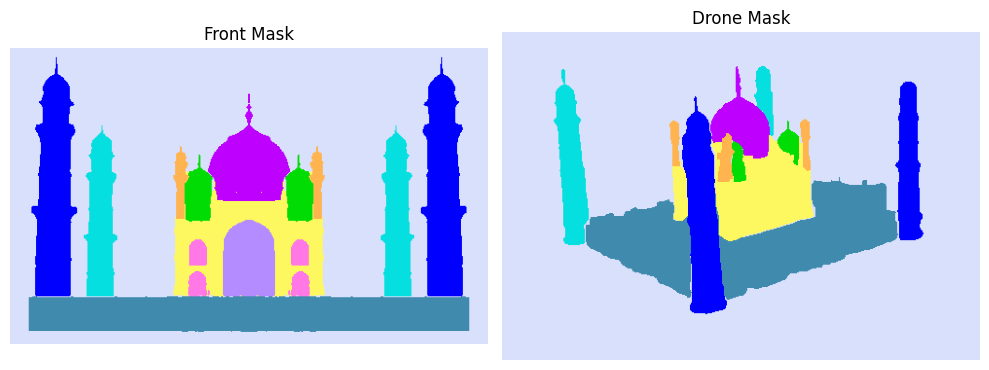

In [14]:
# --- Config ---
project_root = Path.cwd()
data_root = project_root / "data"
monuments = ["Akbar","Bibi","Charminar","Itimad","Taj"]

monument_name = monuments[1]

# Choose source: "results" (precomputed) or "results_temp" (user run)
RESULTS_SOURCE = "results"   # change to "results_temp" if you already ran notebook 1 on chosen monument

# --- Paths ---
mask_dir = data_root / monument_name / "masks"

voxel_path = (
    project_root
    / RESULTS_SOURCE
    / "1.Orthographic_Voxel_Carving"
    / f"{monument_name}_voxel_grid.npz"
)

# --- Load voxel grid ---
voxel_grid = np.load(voxel_path)["voxel_grid"]

print("Voxel grid shape:", voxel_grid.shape)
print("Loaded from:", voxel_path.resolve())


# --- Load images with optional scaling ---
def load_mask(view, max_dim=None):
    path = os.path.join(mask_dir, f"{monument_name}_{view}_mask.png")
    img = Image.open(path)
    if max_dim:
        w, h = img.size
        scale = max_dim / max(w, h)
        img = img.resize((int(w * scale), int(h * scale)), Image.NEAREST)
    return np.array(img)

# Load images (specify scaling only if needed)
voxel_dim_max = np.max(voxel_grid.shape)
front_mask = load_mask("front", max_dim=voxel_dim_max)   # scaled
drone_mask = load_mask("drone")                # original size
# new_mask = load_mask(f"{view}")

print("Front mask shape:", front_mask.shape)
print("Drone mask shape:", drone_mask.shape)

plt.figure(figsize=(10, 5))
for i, (title, img) in enumerate([("Front", front_mask), ("Drone", drone_mask)]):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{title} Mask")
    plt.axis("off")
plt.tight_layout()
plt.show()

# pts,cols, _ = voxel_grid_to_points(voxel_grid,stride=4)
# plot_voxel(pts,cols)
# plt.imshow(new_mask)

### 4. Camera initialization


📐 Computing initial params for view: front
Estimated scale factor: 1.7874
Adjusted focal length: 1060.66


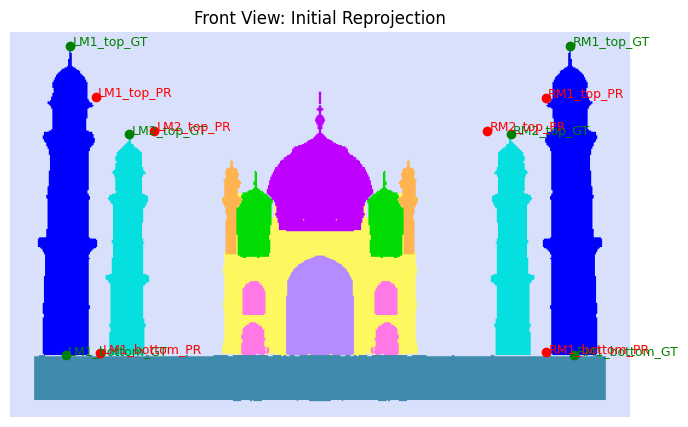


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM2_top | (413.0, 84.0)                  | (393.6, 81.13)                 | 19.61
LM2_top | (98.0, 84.0)                   | (118.54, 81.13)                | 20.74
RM1_bottom | (465.5, 266.0)                 | (442.43, 264.12)               | 23.15
LM1_bottom | (45.5, 266.0)                  | (73.97, 264.54)                | 28.51
RM1_top | (462.0, 11.0)                  | (441.83, 53.87)                | 47.38
LM1_top | (49.0, 11.0)                   | (70.19, 52.95)                 | 47.00

Average Reprojection Error: 31.07 pixels

📐 Computing initial params for view: drone
Estimated scale factor: 1.4510
Adjusted focal length: 912.48


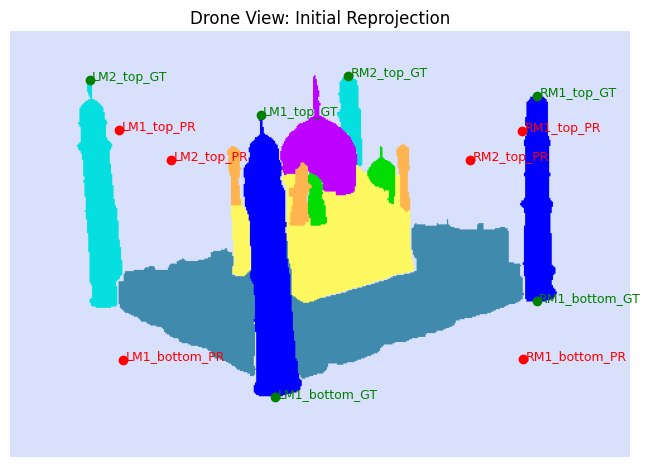


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM2_top | (267.5, 35.0)                  | (363.88, 101.51)               | 117.09
LM2_top | (62.5, 38.0)                   | (127.25, 101.51)               | 90.69
RM1_bottom | (416.5, 213.0)                 | (405.88, 258.93)               | 47.15
LM1_bottom | (209.5, 289.0)                 | (88.9, 259.29)                 | 124.21
RM1_top | (417.0, 51.0)                  | (405.37, 78.06)                | 29.45
LM1_top | (198.0, 66.0)                  | (85.65, 77.27)                 | 112.91

Average Reprojection Error: 86.92 pixels


In [15]:
views = {
    "front": {
        "mask": front_mask,
        "labels": [part_colors['front_minarets'], part_colors['back_minarets']],
    },
    "drone": {
        "mask": drone_mask,
        "labels": [part_colors['front_minarets'], part_colors['back_minarets']],
    }
}

parts_for_alignment = ["front_minarets", "back_minarets"]

init_camera_params = {}
init_keypoints = {}  # store selected keypoints per view

for view_name, cfg in views.items():
    print(f"\n📐 Computing initial params for view: {view_name}")

    mask_img = cfg["mask"]
    minaret_colors = cfg["labels"]

    try:
        voxel_parts = extract_minaret_voxels_by_label(voxel_grid, minaret_colors)
        mask_parts = extract_minaret_masks_by_label(mask_img, minaret_colors)
    except Exception as e:
        print(f"⚠️ Skipping view '{view_name}' due to extraction error: {e}")
        continue

    available_parts = list(set(voxel_parts.keys()) & set(mask_parts.keys()))
    if len(available_parts) < 2:
        print(f"⚠️ Not enough parts visible in view '{view_name}', skipping.")
        continue

    voxel_sel = {k: voxel_parts[k] for k in available_parts}
    mask_sel = {k: mask_parts[k] for k in available_parts}

    voxel_kps = extract_top_bottom_voxel_points(voxel_sel)
    image_kps = extract_top_bottom_image_points(mask_sel)

    voxel_kps_sel = {
        k: voxel_kps[k]
        for k in voxel_kps
        if ('1' in k) or ('2' in k and 'top' in k)
    }

    image_kps_sel = {
        k: image_kps[k]
        for k in image_kps
        if ('1' in k) or ('2' in k and 'top' in k)
    }

    matching_keys = list(set(voxel_kps_sel.keys()) & set(image_kps_sel.keys()))
    if len(matching_keys) < 2:
        print(f"⚠️ Not enough matching keypoints in '{view_name}', skipping.")
        continue

    voxel_kps_sel = {k: voxel_kps_sel[k] for k in matching_keys}
    image_kps_sel = {k: image_kps_sel[k] for k in matching_keys}

    try:
        init_params = auto_compute_initial_params_matching_bbox(
            voxel_grid,
            mask_img,
            part_colors,
            parts_for_alignment=parts_for_alignment,
            fov_deg=30
        )
    except Exception as e:
        print(f"⚠️ Failed to compute init params for '{view_name}': {e}")
        continue

    visualize_reprojection(
        mask_img,
        voxel_kps_sel,
        image_kps_sel,
        init_params,
        title=f"{view_name.capitalize()} View: Initial Reprojection"
    )

    init_camera_params[view_name] = init_params
    init_keypoints[view_name] = {
        "voxel": voxel_kps_sel,
        "image": image_kps_sel,
        "mask": mask_img
    }


### 5. Keypoint-based optimization


🎯 Optimizing camera for view: front

📷 Optimized Camera Parameters:
cam_pos: [  261.51138881    39.27365069 -1136.44215156]
target: [249.1070705   -8.51527602  92.62421647]
f: 1201.5925596515826
cx: 246.78232553411823
cy: 318.0
📉 Final Reprojection Loss: 250.34


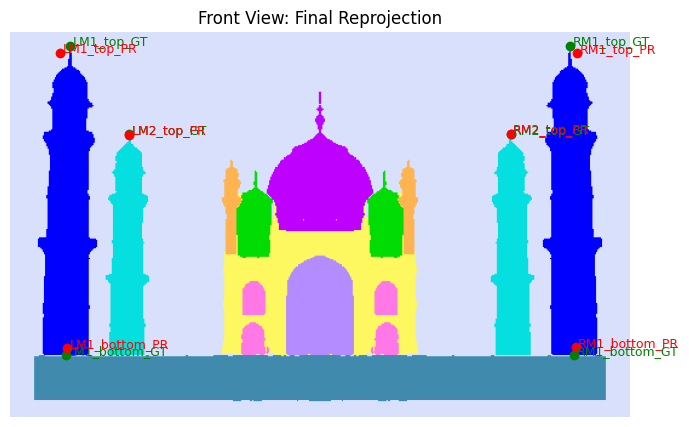


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM2_top | (413.0, 84.0)                  | (412.93, 83.75)                | 0.26
LM2_top | (98.0, 84.0)                   | (98.06, 84.26)                 | 0.26
RM1_bottom | (465.5, 266.0)                 | (466.68, 259.35)               | 6.76
LM1_bottom | (45.5, 266.0)                  | (46.77, 260.45)                | 5.69
RM1_top | (462.0, 11.0)                  | (467.71, 17.13)                | 8.38
LM1_top | (49.0, 11.0)                   | (40.85, 16.95)                 | 10.09

Average Reprojection Error: 5.24 pixels
Visualizing combined binary projection vs. binary ground-truth...


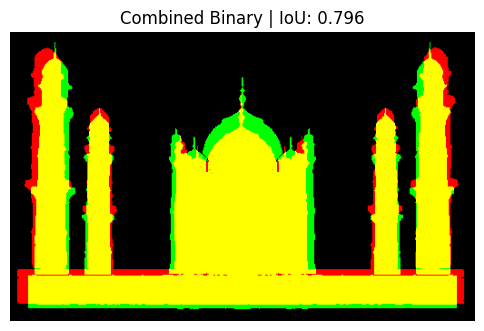


🎯 Optimizing camera for view: drone

📷 Optimized Camera Parameters:
cam_pos: [-221.29538009  342.03077033 -419.46895243]
target: [150.51184318 -81.32670626  25.96168441]
f: 454.39222829731364
cx: 283.4011083299935
cy: 337.0
📉 Final Reprojection Loss: 856.18


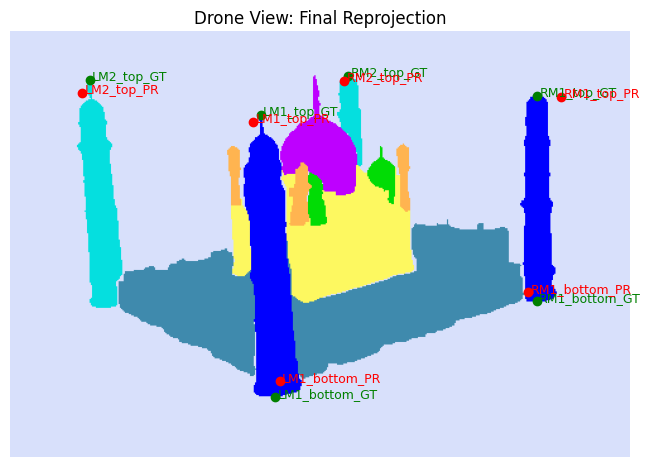


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM2_top | (267.5, 35.0)                  | (264.03, 38.51)                | 4.94
LM2_top | (62.5, 38.0)                   | (56.4, 48.41)                  | 12.07
RM1_bottom | (416.5, 213.0)                 | (409.95, 205.73)               | 9.79
LM1_bottom | (209.5, 289.0)                 | (212.99, 276.21)               | 13.26
RM1_top | (417.0, 51.0)                  | (435.69, 51.12)                | 18.69
LM1_top | (198.0, 66.0)                  | (191.94, 71.35)                | 8.08

Average Reprojection Error: 11.14 pixels
Visualizing combined binary projection vs. binary ground-truth...


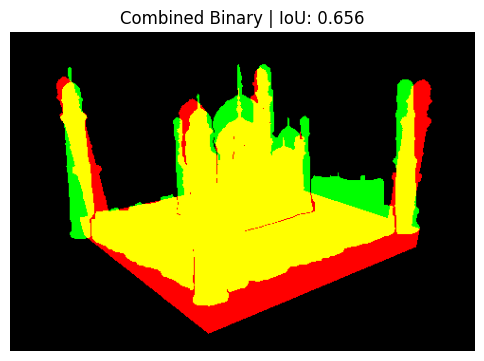

In [26]:
kp_camera_params = {}

for view_name, data in init_keypoints.items():
    print(f"\n🎯 Optimizing camera for view: {view_name}")

    init_params = init_camera_params[view_name]
    voxel_kps_sel = data["voxel"]
    image_kps_sel = data["image"]
    mask_img = data["mask"]

    final_params = optimize_camera_with_keypoints(
        voxel_keypoints_dict=voxel_kps_sel,
        image_keypoints_dict=image_kps_sel,
        image=mask_img,
        init_params=init_params,
        loss_type='L2'
    )

    kp_camera_params[view_name] = final_params

    visualize_reprojection(
        mask_img,
        voxel_kps_sel,
        image_kps_sel,
        final_params,
        title=f"{view_name.capitalize()} View: Final Reprojection"
    )

    visualize_voxel_projection_iou(
        voxel_grid,
        part_colors,
        mask_img,
        final_params,
        mode='whole_on_whole'
    )


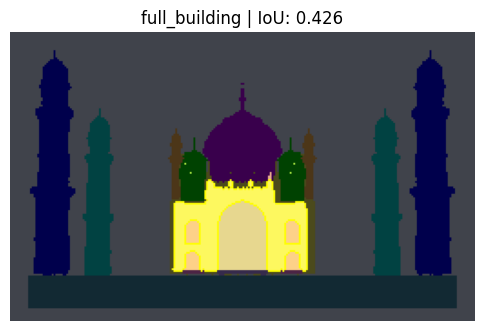

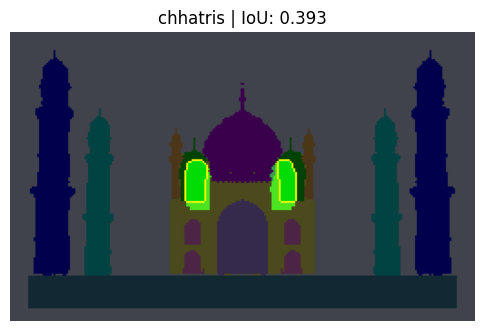

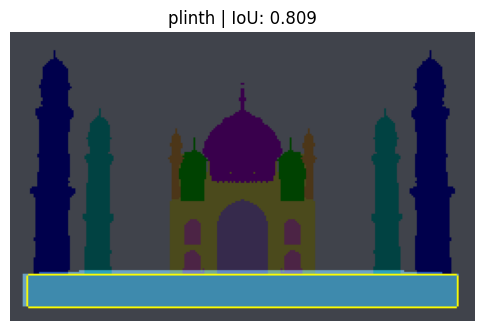

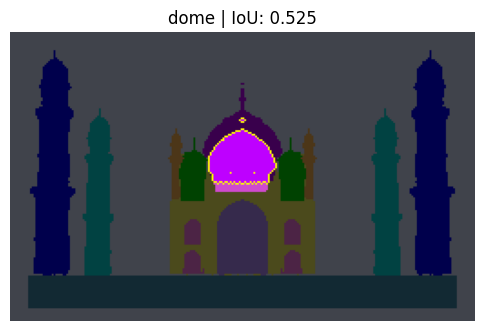

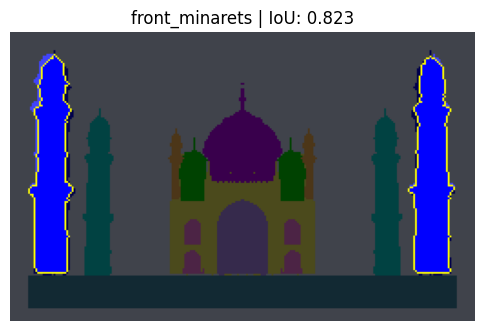

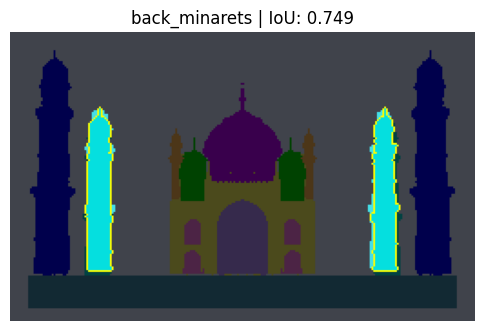

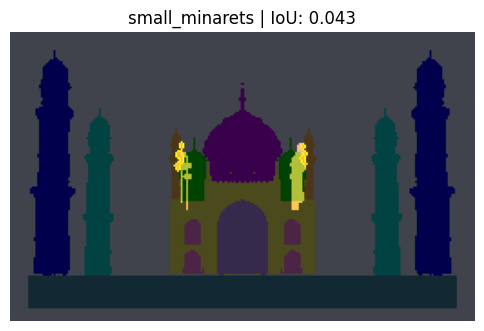

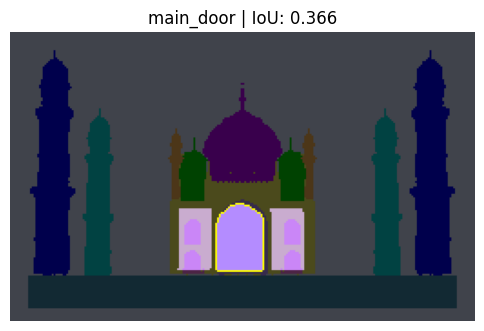

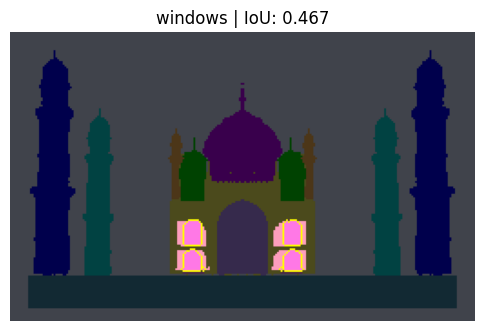

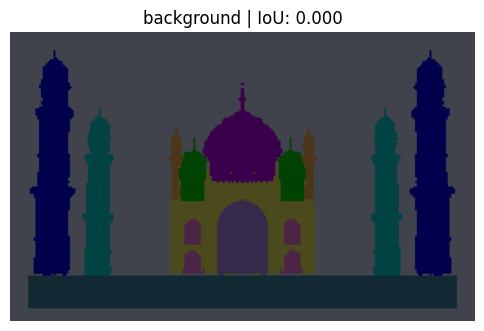

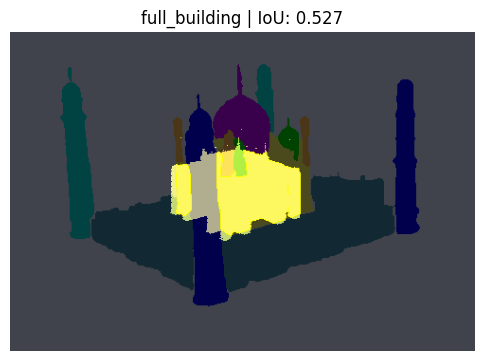

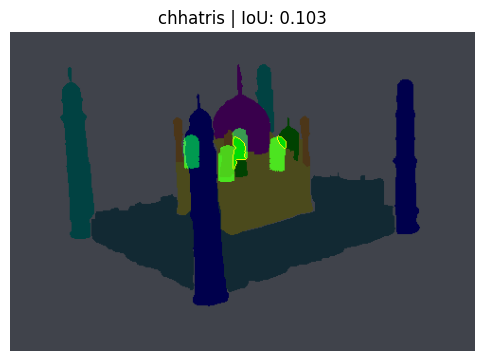

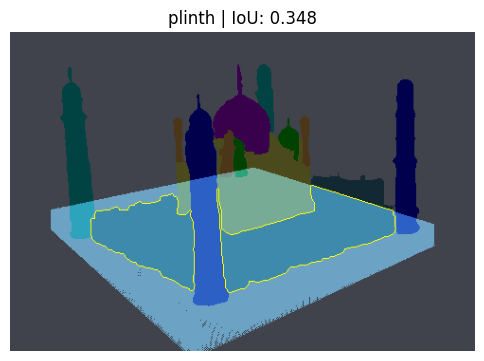

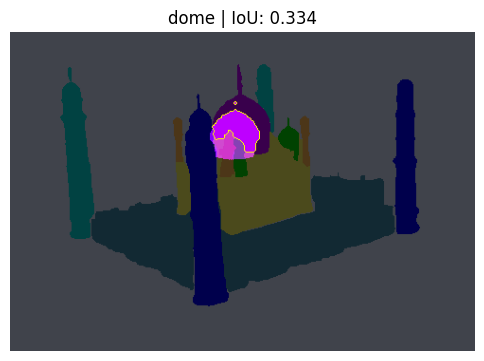

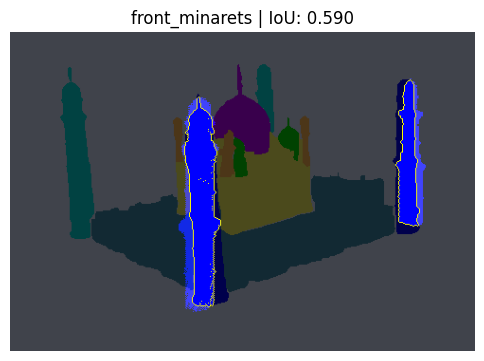

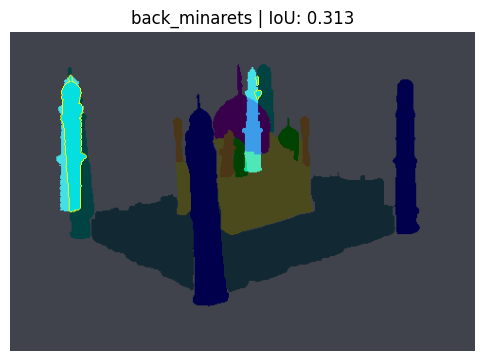

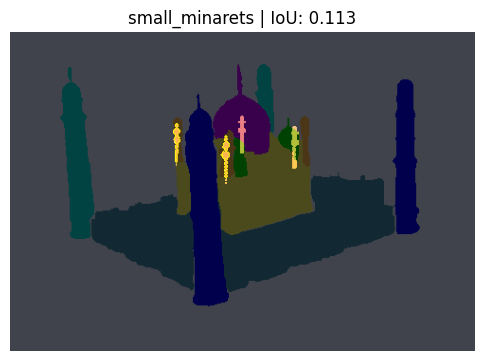

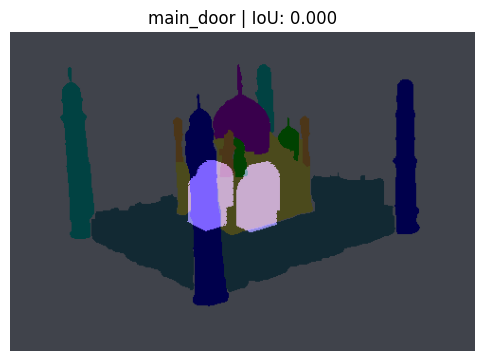

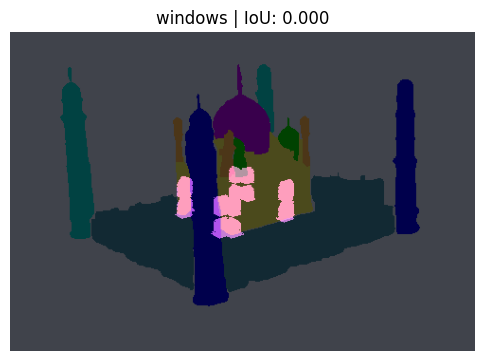

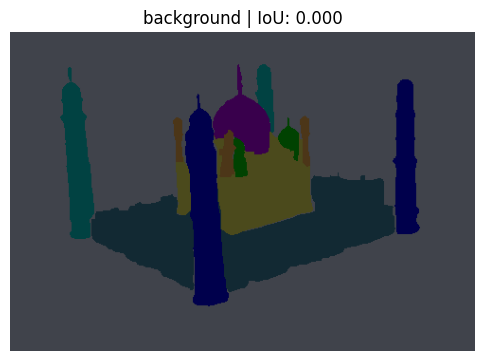

In [94]:
for view_name, data in init_keypoints.items():
    mask_img = data["mask"]
    params_kp = kp_camera_params[view_name] 
    visualize_voxel_projection_iou(voxel_grid, part_colors, mask_img, params_kp, mode='part_on_whole')


### 6. Mask-based optimization

In [27]:
# view_name = 'front'
# view_name = 'drone'
final_camera_params = {}
for view_name in ['front','drone']:
    im,cam = views[view_name]['mask'],kp_camera_params[view_name]
    final_camera_params[view_name] = launch_smart_aligner(
        voxel_grid,
        im,
        part_colors,
        # parts_for_alignment=list(part_colors.keys()),
        parts_for_alignment= ["front_minarets","back_minarets"],
        init_params=kp_camera_params[view_name]

    )

### 7. Save camera params

In [32]:
import json

def to_json_safe(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: to_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_json_safe(v) for v in obj]
    return obj

# --- Config ---
project_root = Path.cwd()

out_dir = (
    project_root
    / "results_temp"
    / "2.Perspective_Camera_Estimation"
)
out_dir.mkdir(parents=True, exist_ok=True)

# --- Camera parameter sets ---
camera_sets = {
    "init":  init_camera_params,
    "kp":    kp_camera_params,
    "final": final_camera_params
}

# --- Save ---
for tag, params in camera_sets.items():
    path = out_dir / f"{monument_name}_camera_params_{tag}.json"
    with open(path, "w") as f:
        json.dump(to_json_safe(params), f, indent=2)
    print(f"Saved: {path.resolve()}")


Saved: /home/sanju/mycode/O2P3D_final_paper/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_init.json
Saved: /home/sanju/mycode/O2P3D_final_paper/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_kp.json
Saved: /home/sanju/mycode/O2P3D_final_paper/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_final.json
